In [2]:
%matplotlib inline

In [3]:
import numpy as np
import nibabel as nb
import scipy.stats as stats
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
import seaborn as sns

### Load gradients and cell data

In [4]:
img = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz')
mask = img.get_data()
aff = img.affine
hdr = img.header

In [5]:
x = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/x2vol_200.npy')
y = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/y2vol_200.npy')
z = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/z2vol_200.npy')
types = np.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/types.npy')

Types probably:
0 - excitatory neurons;
1 - inhibitory neurons;
2 - oligodendrocytes;
3 - astrocytes;
4 - microglia;

### Make a cell density map

In [6]:
cell_density = np.zeros_like(mask)
for c in range(len(x)):
    voxel = (int(np.floor(x[c])), int(np.floor(y[c])), int(np.floor(z[c])))
    if not mask[voxel] == 0:
        cell_density[voxel] +=  1

In [8]:
nb.save(nb.Nifti1Image(cell_density, aff, hdr), 
        '/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_200um.nii.gz')

### Smooth cell density map with same kernel as gradient

In [9]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=img, standardize=True, smoothing_fwhm=0.45)
smoothed_trans = masker.fit_transform('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_200um.nii.gz')

/home/julia/workspace/nilearn/nilearn/signal.py:61: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


In [10]:
smoothed = masker.inverse_transform(smoothed_trans)
smoothed.to_filename('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_200um_smooth045.nii.gz')
cell_density = smoothed.get_data().squeeze()

### Calcluate Spearman correlation to gradients

In [13]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
for g in range(6):
    gradient =  gradients[:,:,:,g]
    print('Gradient %i:' %g, stats.spearmanr(cell_density[mask==1], gradient[mask==1]))

Gradient 0: SpearmanrResult(correlation=0.35947376866556163, pvalue=0.0)
Gradient 1: SpearmanrResult(correlation=-0.14260341427436848, pvalue=7.213482604128383e-71)
Gradient 2: SpearmanrResult(correlation=0.15535066845250417, pvalue=6.52185892749864e-84)
Gradient 3: SpearmanrResult(correlation=0.07619438831318912, pvalue=2.6616038765566323e-21)
Gradient 4: SpearmanrResult(correlation=-0.3495301885713016, pvalue=0.0)
Gradient 5: SpearmanrResult(correlation=0.0941083601074182, pvalue=1.1072908156051085e-31)


### Plot

In [11]:
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()
template = nb.load('/home/julia/data/gradients/atlas/allen_api/template_200.nii.gz').get_data()
cell_density = nb.load('/home/julia/data/gradients/atlas/epfl_cell_atlas/cortex_cells_200um_smooth045.nii.gz').get_data().squeeze()
mask = nb.load('/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz').get_data()

In [12]:
cell_density[mask==0] = np.nan
gradient_0 = gradients[:,:,:,0]
gradient_0[mask==0] = np.nan
gradient_4 = gradients[:,:,:,4]
gradient_4[mask==0] = np.nan

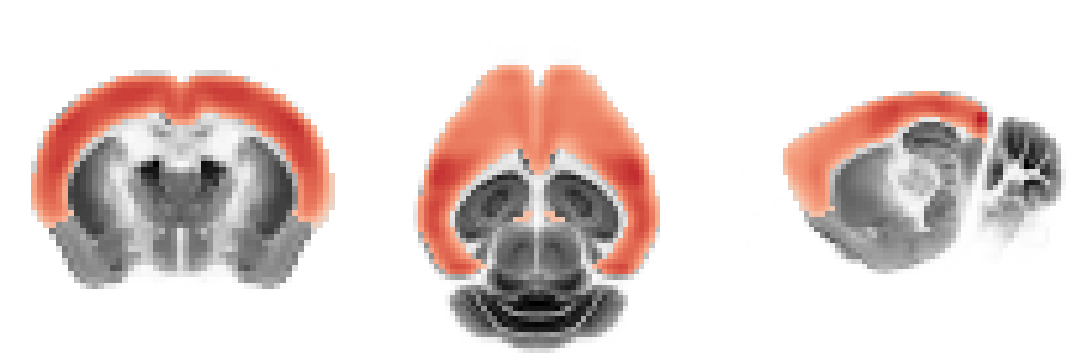

In [24]:
x=30
y=10
z=15


fig = plt.figure(figsize=(15,15))

vmin = -max(np.abs(np.nanmin(cell_density)), np.abs(np.nanmax(cell_density)))
vmax = max(np.abs(np.nanmin(cell_density)), np.abs(np.nanmax(cell_density)))

fig.add_subplot(3,3,1)
plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
plt.imshow(cell_density[x,:,:],  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(3,3,2)
plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
plt.imshow(cell_density[:,y,:],  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

fig.add_subplot(3,3,3)
plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
plt.imshow(cell_density[:,:,z].T,  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
plt.axis('off');

# vmin = np.nanmin(gradient_0)
# vmax = np.nanmax(gradient_0)

# fig.add_subplot(3,3,4)
# plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_0[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,5)
# plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_0[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,6)
# plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
# plt.imshow(gradient_0[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# vmin = np.nanmin(gradient_4)
# vmax = np.nanmax(gradient_4)

# fig.add_subplot(3,3,7)
# plt.imshow(template[x,:,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_4[x,:,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,8)
# plt.imshow(template[:,y,:],  cmap='Greys', aspect='equal');
# plt.imshow(gradient_4[:,y,:],  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

# fig.add_subplot(3,3,9)
# plt.imshow(template[:,:,z].T,  cmap='Greys', aspect='equal');
# plt.imshow(gradient_4[:,:,z].T,  cmap="cubehelix", aspect='equal', vmin=vmin, vmax=vmax);
# plt.axis('off');

plt.tight_layout()